In [1]:
import numpy as np                                      # for dealing with data
from scipy.signal import butter, sosfiltfilt, sosfreqz  # for filtering
import matplotlib.pyplot as plt                         # for plotting
import pandas as pd
import os
from os import listdir
from os.path import isfile, join, isdir
from generate_epoch import *
from sklearn.linear_model import LogisticRegression
import pickle

from pystacknet.pystacknet import StackNetClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [2]:
train_list_arr = np.array(sorted(listdir('data/train')))
total_training_participant = 9
trial_per_subj = 3 # 9 x 3 = 27 csv files in total
train_list_arr = train_list_arr[1:]
train_list_np = np.reshape(train_list_arr, (total_training_participant,trial_per_subj))
test_list_arr = np.array(sorted(listdir('data/test')))
total_testing_participant = 9
test_trial_per_subj = 2
test_list_arr = test_list_arr[1:]
test_list_np = np.reshape(test_list_arr, (total_testing_participant,test_trial_per_subj))

In [3]:
train_list_np

array([['B0101T.csv', 'B0102T.csv', 'B0103T.csv'],
       ['B0201T.csv', 'B0202T.csv', 'B0203T.csv'],
       ['B0301T.csv', 'B0302T.csv', 'B0303T.csv'],
       ['B0401T.csv', 'B0402T.csv', 'B0403T.csv'],
       ['B0501T.csv', 'B0502T.csv', 'B0503T.csv'],
       ['B0601T.csv', 'B0602T.csv', 'B0603T.csv'],
       ['B0701T.csv', 'B0702T.csv', 'B0703T.csv'],
       ['B0801T.csv', 'B0802T.csv', 'B0803T.csv'],
       ['B0901T.csv', 'B0902T.csv', 'B0903T.csv']], dtype='<U10')

In [4]:
test_list_np

array([['B0104E.csv', 'B0105E.csv'],
       ['B0204E.csv', 'B0205E.csv'],
       ['B0304E.csv', 'B0305E.csv'],
       ['B0404E.csv', 'B0405E.csv'],
       ['B0504E.csv', 'B0505E.csv'],
       ['B0604E.csv', 'B0605E.csv'],
       ['B0704E.csv', 'B0705E.csv'],
       ['B0804E.csv', 'B0805E.csv'],
       ['B0904E.csv', 'B0905E.csv']], dtype='<U10')

epoching all training and testing data

In [5]:
stimulus_per_subj = 360
stimulus_per_subj_test = 240
channels = ['C3','Cz','C4']
epoch_s = 0
epoch_e = 4000 #4 seconds
fs = 250
epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))
train_data_list = np.empty((0, stimulus_per_subj, len(channels), epoch_len), float)
test_data_list = np.empty((0, stimulus_per_subj_test, len(channels), epoch_len), float)

In [6]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
#     filted_data = sosfiltfilt(sos, data)
#     return filted_data
    return data

In [7]:
lowcut = 0.5
highcut = 100
bl_s = -400
bl_e = -300
for training_participant_id in range(total_training_participant):
    subject_dir_list = train_list_np[training_participant_id]
    subject_epoch = np.empty((0, len(channels), epoch_len), float)
    for trial_id in range(trial_per_subj):
        subject_dir = subject_dir_list[trial_id]
        data = generate_epoch(file_path = 'data/train/'+subject_dir, channels = channels, \
                              eeg_filter = butter_bandpass_filter, fs = fs, epoch_s = epoch_s, \
                              epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
        subject_epoch = np.vstack((subject_epoch, data))
    subject_epoch = np.reshape(subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
    train_data_list = np.vstack((train_data_list, subject_epoch))

print('Epoched training data shape: '+ str(train_data_list.shape))

for testing_participant_id in range(total_testing_participant):
    subject_dir_list = test_list_np[testing_participant_id]
    subject_epoch = np.empty((0, len(channels), epoch_len), float)
    for trial_id in range(test_trial_per_subj):
        subject_dir = subject_dir_list[trial_id]
        data = generate_epoch(file_path = 'data/test/'+subject_dir, channels = channels, \
                              eeg_filter = butter_bandpass_filter, fs = fs, epoch_s = epoch_s, \
                              epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
        subject_epoch = np.vstack((subject_epoch, data))
    subject_epoch = np.reshape(subject_epoch, (1, stimulus_per_subj_test, len(channels), epoch_len))
    test_data_list = np.vstack((test_data_list, subject_epoch))

print('Epoched testing data shape: '+ str(test_data_list.shape))

Epoched training data shape: (9, 360, 3, 1000)
Epoched testing data shape: (9, 240, 3, 1000)


Load Labels

In [8]:
y = pd.read_csv('data/TrainLabels.csv', header = None)
y = y.values.reshape(3240,)
print(y.shape)
yT = pd.read_csv('data/true_labels.csv', header = None) # put your train label path here
yT = yT.values.reshape(2160,)
print(yT.shape)

(3240,)
(2160,)


Preprocessing with XDawn + TangentSpace Transform

In [9]:
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
XC = XdawnCovariances(nfilter=1)
output = XC.fit_transform(np.reshape(train_data_list, (9*360, 3, 1000)), y)
print(output.shape)
output = TangentSpace(metric='riemann').fit_transform(output)
print(output.shape)

(3240, 4, 4)
(3240, 10)


In [10]:
outputT = XC.fit_transform(np.reshape(test_data_list, (9*240, 3, 1000)), yT)
outputT = TangentSpace(metric='riemann').fit_transform(outputT)
outputT.shape

(2160, 10)

In [11]:
X = np.reshape(output, (9, 360, 10))
data_train = X[:6]
data_test = X[-3:]
print(data_train.shape, data_test.shape)

(6, 360, 10) (3, 360, 10)


In [12]:
# data split
y_train, y_test = np.array([]), np.array([])
y_train = y

y_test = yT

X_train = output

X_test = outputT

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3240, 10) (3240,) (2160, 10) (2160,)


In [13]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
y_pred = logreg.predict(X_test)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1080
           1       0.70      0.70      0.70      1080

    accuracy                           0.70      2160
   macro avg       0.70      0.70      0.70      2160
weighted avg       0.70      0.70      0.70      2160



In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'n_estimators': [100, 200, 300, 1000]
}

# Fit the grid search to the data
if not isfile('random_forest_gs'): 
    rf = RandomForestClassifier()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
               cv = 4, n_jobs = -1)
    grid_search.fit(X_train, y_train)
    pickle.dump(grid_search, open('random_forest_gs', 'wb'))

In [17]:
grid_search = pickle.load(open('random_forest_gs', 'rb'))
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'n_estimators': 1000}


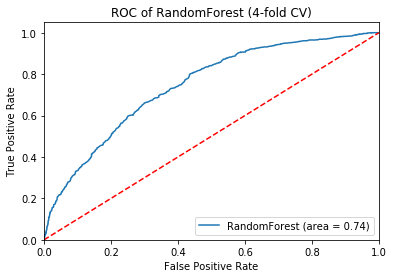

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

# Predict the probability of our label score
Y_pred_proba = grid_search.predict_proba(X_test)

r_roc_auc = roc_auc_score(y_test, Y_pred_proba[:,1])
fpr, tpr, thresholds = roc_curve(y_test, Y_pred_proba[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForest (area = %0.2f)' % r_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of RandomForest (4-fold CV)')
plt.legend(loc="lower right")
#plt.savefig('images2/Randomforest_ROC')
plt.show()

StackNet

In [19]:
models = [
    #1ST layer #
    [GridSearchCV(LDA(solver='lsqr'),  {'shrinkage': (0.01, 0.1, 1.)}, cv=3, n_jobs=-1),
     GridSearchCV(SVC(class_weight='balanced', probability=True),  {'kernel': [
                  'rbf'], 'gamma': [10**(-2), 10**(-3)], 'C': [100, 10, 1, 0.1]}, cv=3, n_jobs=-1),
     GridSearchCV(LogisticRegression(class_weight='balanced',
                                     solver='lbfgs', max_iter=100000), {'C': [100, 10, 1, 0.1]}, cv=3, n_jobs=-1),
     LGBMClassifier(boosting_type='gbdt', num_leaves=40, max_depth=-1, learning_rate=0.01, n_estimators=1000, class_weight='balanced', subsample_for_bin=1000, objective="xentropy",
                    min_split_gain=0.0, min_child_weight=0.01, min_child_samples=10, subsample=0.9, subsample_freq=1, colsample_bytree=0.5, reg_alpha=0.0, reg_lambda=0.0, random_state=1, n_jobs=1),
     GaussianProcessClassifier(),
     XGBClassifier(max_depth=5, learning_rate=0.3, reg_lambda=0.1, n_estimators=300,
                   objective="binary:logistic", n_jobs=1, booster="gblinear", random_state=1, colsample_bytree=0.4),
     XGBClassifier(max_depth=20, learning_rate=0.1, n_estimators=300, objective="binary:logistic",
                   n_jobs=1, booster="gbtree", random_state=1, colsample_bytree=0.4),
     XGBClassifier(max_depth=100, learning_rate=0.1, n_estimators=300, objective="rank:pairwise",
                   n_jobs=1, booster="gbtree", random_state=1, colsample_bytree=0.4),
     ],

    #2ND layer #
    [
        RandomForestClassifier(max_depth=50, n_estimators=50),
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
            max_depth=5), n_estimators=200),
        ExtraTreesClassifier(max_depth=5, n_estimators=50),
    ],

    #3RD layer #
    [
        RandomForestClassifier(
            max_depth=5, class_weight='balanced', n_estimators=100),
        SVC(kernel='linear', class_weight='balanced', probability=True),
        MLPClassifier(hidden_layer_sizes=(32, 16), activation="relu", solver="sgd", alpha=0.01,
                      batch_size=30, learning_rate="adaptive", learning_rate_init=0.001, power_t=0.5,
                      max_iter=100, shuffle=True, random_state=1, tol=0.0001, nesterovs_momentum=True, momentum=0.9, validation_fraction=0.1, early_stopping=True,
                      beta_1=0.1, beta_2=0.1, epsilon=0.1)
    ]
]

In [20]:
# leave 4 subject out
kf = KFold(4)
generator = kf.split(X_train, y_train)

# build StackNet
stacknet = StackNetClassifier(models, metric="auc", folds=generator, 
           restacking=False, use_retraining=True, use_proba=True,
           n_jobs=-1, verbose=1)

In [21]:

# make predictions
# if not isfile('data/stacknet_prediction.npy'):
#     stacknet.fit(X_train, y_train)
#     y_probs = stacknet.predict_proba(X_test)[:, 1]
#     np.save('data/stacknet_prediction.npy', y_probs)

EEGNet

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint

In [23]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.),
                                  data_format='channels_first')(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4), data_format='channels_first')(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8), data_format='channels_first')(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [24]:
subj, trial, channel, sample = train_data_list.shape
X_train_valid = np.reshape(train_data_list, (-1, 1, channel, sample))
X_test = np.reshape(test_data_list, (-1, 1, channel, sample))

Y_train_valid = pd.read_csv('data/TrainLabels.csv', header = None).values
split_thres = int(subj * trial * 0.25)
X_train, X_valid = X_train_valid[split_thres:, :], X_train_valid[:split_thres, :]
Y_train, Y_valid = Y_train_valid[split_thres:], Y_train_valid[:split_thres]

print('training data shape: ' + str(X_train.shape))
print('validation data shape: ' + str(X_valid.shape))
print('testing data shape: ' + str(X_test.shape))
print(Y_train.shape, Y_valid.shape)

training data shape: (2430, 1, 3, 1000)
validation data shape: (810, 1, 3, 1000)
testing data shape: (2160, 1, 3, 1000)
(2430, 1) (810, 1)


In [25]:
# configure EEGNET model
model = EEGNet(nb_classes=2, Chans=channel, Samples=sample)

# compile the model and set the optimizers
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 3, 1000)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 3, 8)           512000    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 3, 8)           4         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 2, 1, 8)           6         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 1, 8)           8         
_________________________________________________________________
activation (Activation)      (None, 2, 1, 8)           0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 2, 1, 2)          

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)
# Weighted loss
weight_0 = 1/(len([y for y in Y_train_valid if y == 0]))
weight_1 = 1/(len([y for y in Y_train_valid if y == 1]))
class_weights = {0: weight_0, 1: weight_1}

#
# # fit the model
fittedModel = model.fit(X_train, Y_train, batch_size=32, epochs=100,
        verbose=2, validation_data=(X_valid, Y_valid),
        callbacks=[checkpointer], class_weight=class_weights)

In [28]:
# print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))